In [52]:
# 訓練データとテストデータの画像を読み込む
# （サイズは縦横75pxにリサイズする）
import tensorflow as tf

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dog_cat_photos/train",
    image_size=(75, 75),
    label_mode="binary",
    batch_size=32,
    shuffle=True
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dog_cat_photos/test",
    image_size=(75, 75),
    label_mode="binary",
    batch_size=32,
    shuffle=False
)

Found 300 files belonging to 2 classes.
Found 100 files belonging to 2 classes.


In [53]:
# データの詳細を表示する
list(train_dataset.as_numpy_iterator())[0]

2025-08-15 12:39:50.703579: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(array([[[[194., 208., 185.],
          [198., 211., 193.],
          [189., 201., 187.],
          ...,
          [221., 219., 243.],
          [123., 119., 146.],
          [153., 147., 181.]],
 
         [[194., 208., 193.],
          [196., 209., 199.],
          [189., 202., 193.],
          ...,
          [203., 199., 222.],
          [129., 125., 150.],
          [164., 159., 191.]],
 
         [[190., 205., 198.],
          [192., 204., 200.],
          [189., 201., 197.],
          ...,
          [178., 179., 209.],
          [133., 134., 165.],
          [162., 162., 198.]],
 
         ...,
 
         [[174., 176., 163.],
          [186., 190., 176.],
          [189., 193., 179.],
          ...,
          [142., 142., 132.],
          [147., 145., 133.],
          [149., 147., 135.]],
 
         [[170., 172., 159.],
          [177., 181., 167.],
          [174., 178., 164.],
          ...,
          [119., 119., 109.],
          [126., 123., 114.],
          [131., 128., 119.

In [54]:
# 分類名（no／yes）をリストとして格納する
class_names = train_dataset.class_names
class_names

['cat', 'dog']

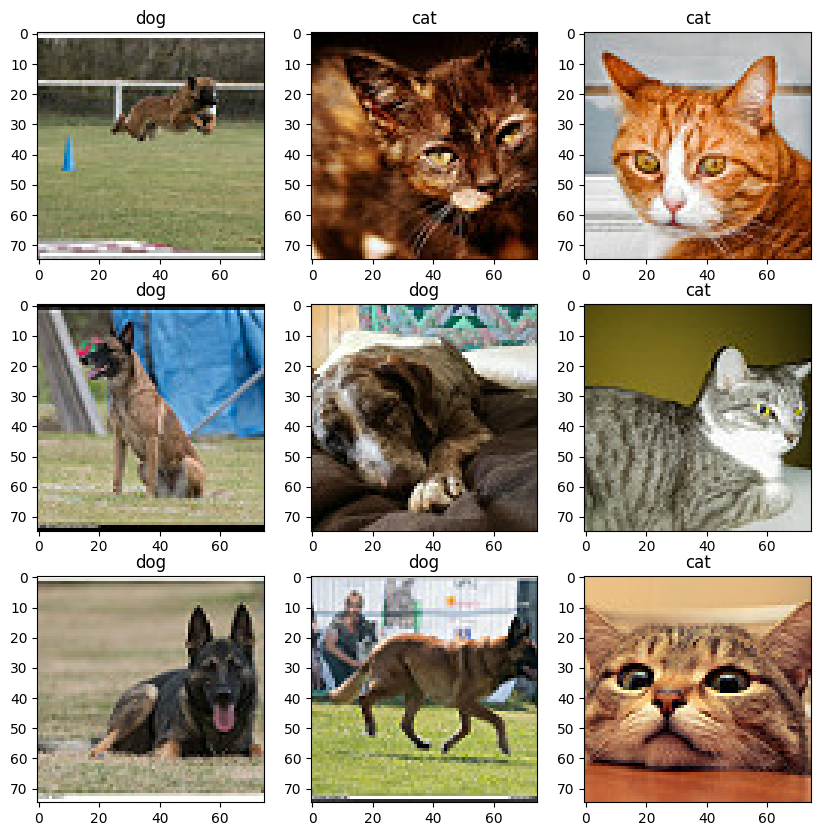

In [55]:
# 訓練データの一部を表示して確認
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().astype("uint8")[0]])

In [56]:
# 画像の水増しをする関数の定義
def flip_left_right(image, label):   # 左右反転
    image = tf.image.flip_left_right(image)
    return image, label

def flip_up_down(image, label):      # 上下反転
    image = tf.image.flip_up_down(image)
    return image, label

def rot90(image, label):             # 反時計回りに90度回転
    image = tf.image.rot90(image)
    return image, label

def rot180(image, label):            # 反時計回りに180度回転
    image = tf.image.rot90(image, k=2)
    return image, label

def rot270(image, label):            # 反時計回りに270度回転
    image = tf.image.rot90(image, k=3)
    return image, label

# 画像の水増し処理の実行
train_dataset_lr     = train_dataset.map(flip_left_right)
train_dataset_ud     = train_dataset.map(flip_up_down)
train_dataset_rot90  = train_dataset.map(rot90)
train_dataset_rot180 = train_dataset.map(rot180)
train_dataset_rot270 = train_dataset.map(rot270)

# 水増ししたデータを訓練データに追加する
train_dataset = train_dataset.concatenate(train_dataset_lr)
train_dataset = train_dataset.concatenate(train_dataset_ud)
train_dataset = train_dataset.concatenate(train_dataset_rot90)
train_dataset = train_dataset.concatenate(train_dataset_rot180)
train_dataset = train_dataset.concatenate(train_dataset_rot270)

# データをシャッフルする
train_dataset = train_dataset.shuffle(32)

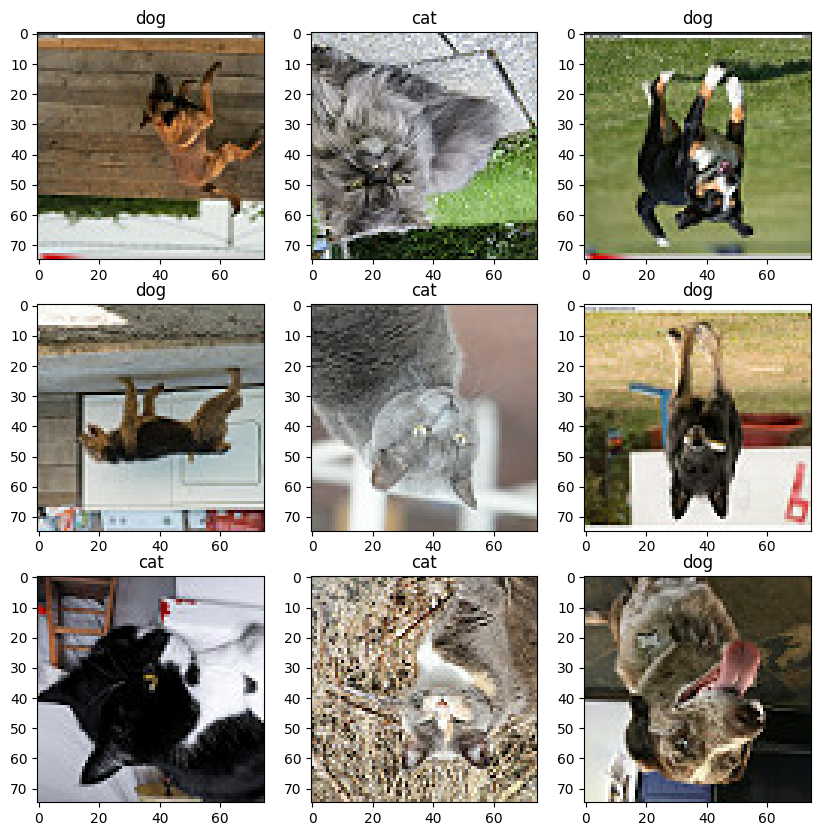

In [57]:
# 訓練データの一部を表示して確認
plt.figure(figsize=(10, 10))

for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().astype("uint8")[0]])

In [58]:
# MobileNetV2モデルを作成する
input_layer = tf.keras.Input(shape=(75, 75, 3))   # 入力層
l_layer = tf.keras.applications.mobilenet_v2.preprocess_input(input_layer)   # 前処理（正規化）をする層

base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(75, 75, 3),
    input_tensor=l_layer,
    include_top=False,
    # weights=None,  # 96 x 96 の画像の場合SSLエラーになるため、weights=Noneにする
    weights='imagenet',
    pooling='avg'
)
# base_model.trainable = True # 96 x 96 の画像を入力する場合は、学習済みの重みを固定しない
base_model.trainable = False  # 転移学習のため、学習済みの重みを固定する

# Dense層を追加する
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')

# base_modelに先ほどのDense層を追加したモデルを作成する
model = tf.keras.Sequential([
    base_model,
    output_layer
])

# modelをcompileする
model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=["accuracy"])

# modelに学習させる
model.fit(train_dataset, epochs=20)

Epoch 1/20


/var/folders/b6/md0nd80s15b9vnjgn6v2w9xh0000gp/T/ipykernel_25954/1288346085.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.7467 - loss: 0.5726
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8817 - loss: 0.2693
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9139 - loss: 0.2006
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9383 - loss: 0.1602
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9500 - loss: 0.1362
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9533 - loss: 0.1270
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9672 - loss: 0.1048
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9733 - loss: 0.0912
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9767 - loss: 0.0831
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9800 - loss: 0.0754
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9828 - loss: 0.0686
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9856 - l

In [59]:
# テストデータで分類を実行する
pred_data = model.predict(test_dataset)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step


In [60]:
# 分類した結果を確認する
pred_data

array([[1.50034055e-02],
       [3.35314071e-05],
       [1.00019518e-02],
       [5.46771626e-05],
       [6.25301269e-04],
       [3.73480259e-03],
       [5.40696492e-04],
       [4.41853739e-02],
       [5.32883161e-04],
       [3.36236879e-02],
       [2.17988600e-05],
       [1.38916835e-01],
       [1.41578715e-03],
       [4.04185690e-02],
       [6.51538488e-04],
       [2.12352239e-02],
       [2.27859869e-04],
       [5.62013686e-03],
       [9.54527990e-04],
       [3.64956250e-05],
       [3.82409635e-05],
       [1.84774661e-04],
       [1.76055153e-04],
       [1.62912835e-03],
       [1.49219617e-01],
       [6.95392072e-01],
       [3.84544730e-01],
       [4.98104855e-05],
       [1.73334464e-01],
       [1.42655190e-04],
       [4.41566408e-01],
       [8.75262022e-01],
       [8.90806696e-05],
       [2.60066073e-02],
       [4.10688408e-02],
       [5.93960658e-02],
       [9.99999821e-01],
       [6.15222845e-04],
       [9.65037763e-01],
       [7.92245032e-07],


In [61]:
# evaluate()でモデルの性能を評価する
model.evaluate(test_dataset)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9500 - loss: 0.2532


[0.25321486592292786, 0.949999988079071]